# MY YOUTUBE HISTORY
### ANALYSIS OF MY BEHAVIOURAL WATCH HISTORY
#### Data Visualization and Analysis of my Youtube Watch History Data
< YEŞİM TOSUN 32205 >

In [54]:
import json
import time
import re
from datetime import datetime
from itertools import islice
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import ttest_1samp, linregress
from scipy.stats import f_oneway
import numpy as np
from scipy.interpolate import make_interp_spline
from scipy.stats import ttest_ind
import seaborn as sns

Some Functions For Parsing Related Data in "video_metadata" File

In [3]:
def category_count(filename):
    category_dict={}
    with open(filename+'.json', 'r', encoding='utf-8') as f:
        data = json.load(f)
    for item in data:
        if 'categoryId' in item:
            category_id = item['categoryId']
            # Update the count of the category in the dictionary
            if category_id in category_dict:
                category_dict[category_id] += 1
            else:
                category_dict[category_id] = 1
    print(category_dict)
    print(len(category_dict))
    return category_dict

def duration_to_minutes(duration_str):
    try:
        total_seconds = int(duration_str)
        result=total_seconds / 60.0
        return round(result)
    except (ValueError, TypeError):
        print('error')
        return 0 

def category_duration(filename):
    category_duration_dict = {}
    with open(filename+'.json', 'r', encoding='utf-8') as f:
        data = json.load(f)
    for item in data:
        category_id = item.get('categoryId')
        duration = duration_to_minutes(item.get('durationv'))
        
        if category_id and duration:
            if category_id in category_duration_dict:
                category_duration_dict[category_id] += duration
            else:
                category_duration_dict[category_id] = duration
    print(category_duration_dict)
    return category_duration_dict

def parse_date(watched_at):
    try:
        dt = datetime.fromisoformat(watched_at.replace('Z', '+00:00'))  # Handle ISO 8601 date with Z
        return dt.strftime('%Y-%m-%d')  # Format as "YYYY-MM-DD"
    except (ValueError, TypeError):
        return None  # Skip invalid dates
    
def date_duration(filename):
    daily_duration = {}
    with open(filename+'.json', 'r', encoding='utf-8') as f:
        data = json.load(f)
    for item in data:
        watched_at = item.get('watched_at')
        duration = duration_to_minutes(item.get('durationv'))
        date = parse_date(watched_at)
        
        if date and duration:
            if date in daily_duration:
                daily_duration[date] += duration
            else:
                daily_duration[date] = duration
   
    for key, value in list(daily_duration.items())[-5:]:
        print(f"{key}: {value}")
    return daily_duration

def extract_category_data(filename):
    with open(filename+'.json', 'r', encoding='utf-8') as f:
        data = json.load(f)
    category_date = []
    for item in data:
        category_id = item.get('categoryId')
        watched_at = item.get('watched_at')
        date = parse_date(watched_at)
        if category_id and date:
            category_date.append((category_id, date))
    print(category_date[0])
    return category_date

Dictionary for the Category ID's Corresponding Names

In [4]:
youtube_categories = {
    1: "Film & Animation",
    2: "Autos & Vehicles",
    10: "Music",
    15: "Pets & Animals",
    17: "Sports",
    20: "Gaming",
    22: "People & Blogs",
    23: "Comedy",
    24: "Entertainment",
    25: "News & Politics",
    26: "Howto & Style",
    27: "Education",
    28: "Science & Technology",
    29: "Nonprofits & Activism",
    33: "Classics",
    44: "Trailers"
}

Eliminating the Categories which are Relatively Less Watched than Others                                     
Converting the Category ID's into their Names using Dictionary "youtube_categories" above

In [5]:
def eliminate_categories(category_counts,minute):
    return {category: minutes for category, minutes in category_counts.items() if minutes >= minute}
def dict_category_numbers_to_names(category_data, category_mapping):#Convert Category Numbers into Category Names
    return {
            category_mapping[int(key)]: value 
            for key, value in category_data.items() 
            if int(key) in category_mapping
        }

In [83]:

def plot_category_pie_chart(category_counts):
    labels = category_counts.keys() 
    sizes = category_counts.values()
    colors = plt.cm.Paired(range(len(labels)))  # Use a colormap for consistent colors

    plt.figure(figsize=(8, 6))
    plt.pie(
        sizes,
        labels=labels,
        autopct='%1.1f%%',  # Show percentages with 1 decimal place
        startangle=90,      # Start from the top of the circle
        colors=colors
    )
    plt.title("All Time Categories Watched")
    plt.axis('equal')  # Equal aspect ratio to ensure the pie is a circle
    plt.show()

# Parse the file and get the relative data
cate_cou=category_count('video_metadata')
category_counts =eliminate_categories (dict_category_numbers_to_names(cate_cou, youtube_categories),100)

{'10': 5565, '27': 2301, '17': 1551, '24': 6359, '22': 6964, '19': 138, '23': 560, '25': 331, '28': 291, '1': 1731, '20': 1637, '26': 1065, '15': 55, '29': 62, '2': 38, '44': 2}
16


#### Plotting Pie Chart of the "ALL TIME WATCH TIMES OF THE CATEGORIES"
There are "quantity(times watched)" and "duration watched" data of the watch history. I wanted to visualize them seperetaly and try to understand the paterns between "times" and "duration". Why are they showing different results?

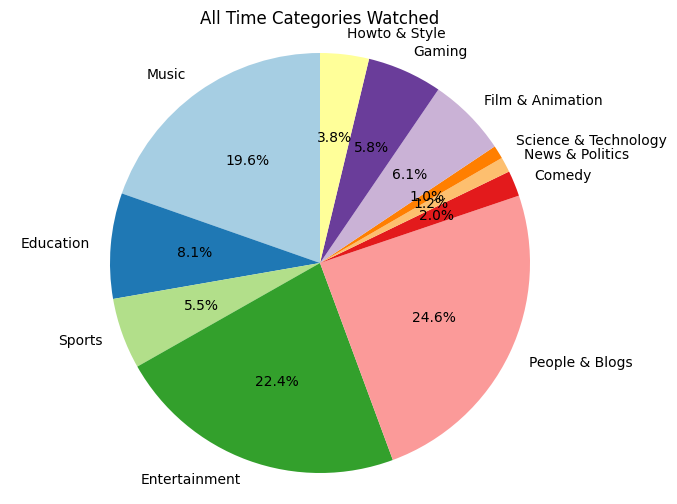

In [86]:
plot_category_pie_chart(category_counts)

#### Pie Chart of "ALL TIME WATCH DURATIONS OF CATEGORIES"

{'10': 29844, '27': 40768, '17': 30921, '24': 55300, '22': 39751, '19': 1375, '23': 3328, '25': 4766, '28': 2957, '1': 16283, '20': 66885, '26': 9324, '15': 44, '29': 308, '2': 107, '44': 4}


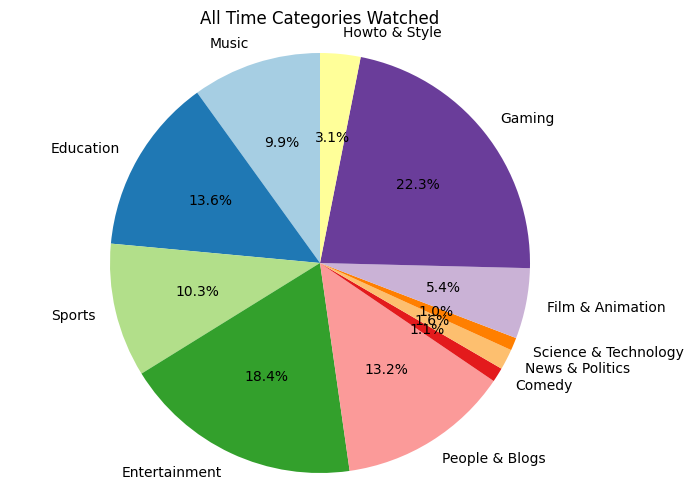

In [85]:
cate_dura =category_duration('video_metadata')
category_durations =eliminate_categories(dict_category_numbers_to_names(cate_dura, youtube_categories),1000)
plot_category_pie_chart(category_durations)

##### As the percentages vary, I wanted to calculate the average video length of my watched category using my own data.

In [115]:
# Function to load and parse the yearly JSON data
def load_yearly_data(year):
    with open(f"video_metadata{year}.json", "r") as file:
        return json.load(file)

# Function to calculate total video duration per year from monthly data
def calculate_yearly_duration(year):
    yearly_data = load_yearly_data(year)
    # Summing up total duration for each month in the year
    total_duration_per_year = sum([month_data["total_duration_minutes"] for month_data in yearly_data])
    return total_duration_per_year


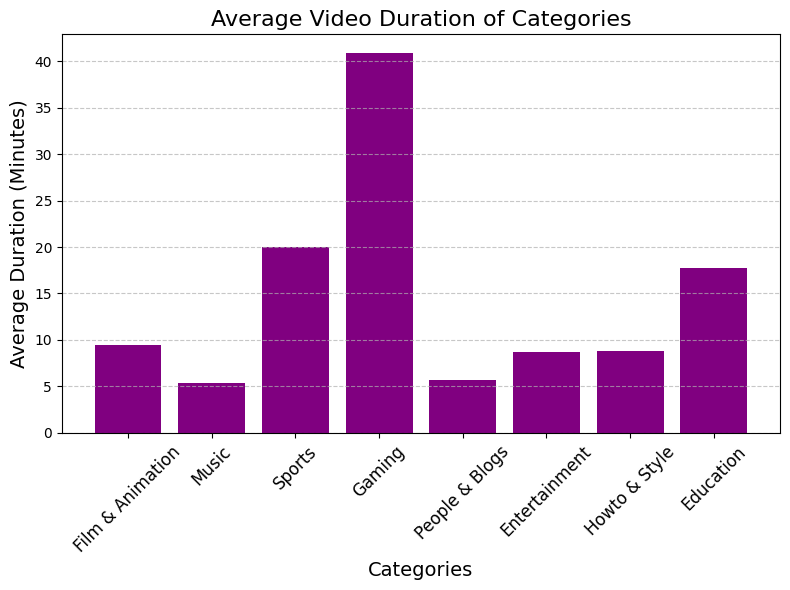

In [116]:
def analyze_category_durations(years, categories):
    category_durations = {c: 0 for c in categories}
    category_counts = {c: 0 for c in categories}
    
    # Aggregate data for each category
    for year in years:
        yearly_data = load_yearly_data(year)
        for month_data in yearly_data:
            for c in categories:
                category_durations[c] += month_data["categories_duration_minutes"].get(str(c), 0)
                category_counts[c] += month_data["categories_count"].get(str(c), 0)
    
    # Calculate average durations
    avg_durations = {}
    for c in categories:
        avg_durations[c] = category_durations[c] / category_counts[c] if category_counts[c] > 0 else 0
    
    # Prepare for visualization
    category_names = [youtube_categories.get(int(c), "Unknown") for c in categories]
    avg_durations_list = [avg_durations[c] for c in categories]
    
    # Plot results
    plt.figure(figsize=(8, 6))
    plt.bar(category_names, avg_durations_list, color='purple')
    plt.title("Average Video Duration of Categories", fontsize=16)
    plt.xlabel("Categories", fontsize=14)
    plt.ylabel("Average Duration (Minutes)", fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    return avg_durations

# Example usage
years_to_analyze = [2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
categories_to_analyze = ["1", "10", "17", "20", "22", "24", "26", "27"]
average_durations = analyze_category_durations(years_to_analyze, categories_to_analyze)


    Observed in the plot, the longest videos i watched are in the category "Gaming" with average length 42 minutes.

**As the data for category watch duration and category watch times differ from each other, I will focus on using "_category watch durations_" for my further analysis. I think this approach will align better with my interests and will provide a more meaningful perspective.

### A Different Visualization of the "ALL TIME WATCH DURATIONS OF VIDEO CATEGORIES" Using Horizontal Bar Chart

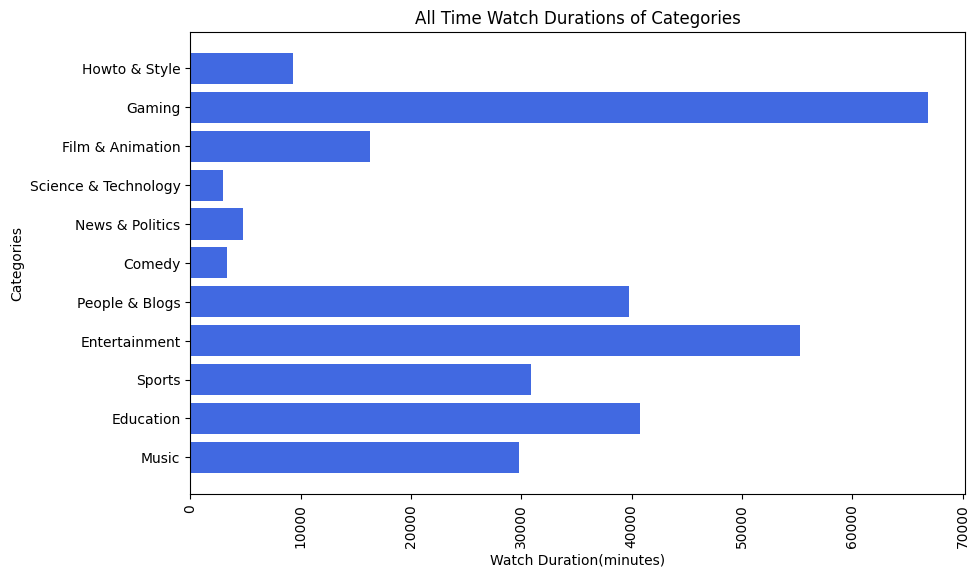

In [9]:
categories = list(category_durations.keys())
durations = list(category_durations.values())
plt.figure(figsize=(10, 6))
plt.barh(categories, durations, color='royalblue')
plt.ylabel('Categories')
plt.xlabel('Watch Duration(minutes)')
plt.title('All Time Watch Durations of Categories')
plt.xticks(rotation=90)
plt.show()

My longest watched categories seem to be: Gaming and Entertainment

## HYPOTHESIS TESTING
### "My watch time has increased significantly over the years."
##### Analysis by using Linear Regression Model 
Null Hypothesis: No significant upward trend in video watch durations.                                                              
Alternative Hypothesis: There is a significant upward trend in video watch durations over the years.


Linear Regression Results:
Slope: 8593.89 (Rate of Change in Duration per Year)
Intercept: -17326158.90
R-squared: 0.5913 (Explains 59.13% of the variance)
P-value: 0.0257
Reject the null hypothesis: There is a significant upward trend in video watch durations over the years.


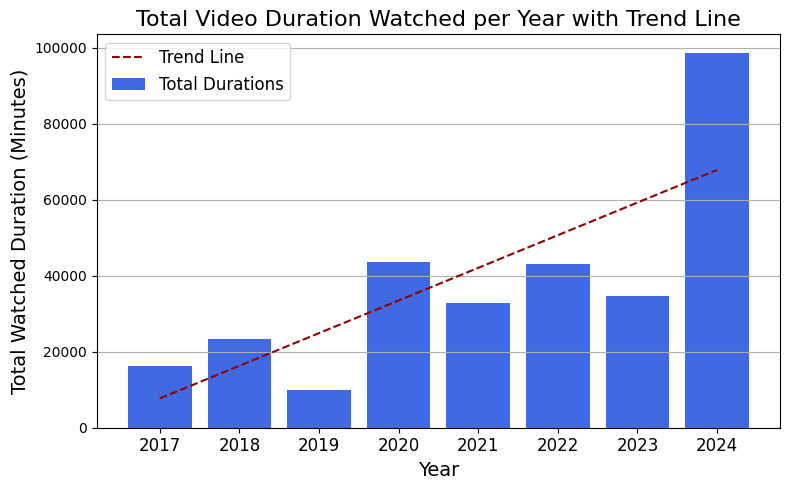

In [87]:
years_to_visualize = [2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
total_durations = [calculate_yearly_duration(year) for year in years_to_visualize]

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(years_to_visualize, total_durations)

# Print results
print(f"Linear Regression Results:")
print(f"Slope: {slope:.2f} (Rate of Change in Duration per Year)")
print(f"Intercept: {intercept:.2f}")
print(f"R-squared: {r_value**2:.4f} (Explains {r_value**2 * 100:.2f}% of the variance)")
print(f"P-value: {p_value:.4f}")

# Interpret the results
if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant upward trend in video watch durations over the years.")
else:
    print("Fail to reject the null hypothesis: No significant upward trend in video watch durations.")

# Visualize total durations and the trend line
plt.figure(figsize=(8, 5))
plt.bar(years_to_visualize, total_durations, color='royalblue', label="Total Durations")
plt.plot(
    years_to_visualize, 
    [slope * year + intercept for year in years_to_visualize], 
    color='darkred', linestyle="--", label="Trend Line"
)
plt.title("Total Video Duration Watched per Year with Trend Line", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Total Watched Duration (Minutes)", fontsize=14)
plt.xticks(years_to_visualize, fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, axis='y', linestyle='-')
plt.tight_layout()
plt.show()


#### My hypothesis is proven right
There is a significant upward trend in my video watch durations over the years.

### "My watch durations are significantly higher in summer."
Null Hypothesis: No significant difference in summer watch durations.                          
Alternative Hypothesis: Watch durations are significantly higher in summer.

In [ ]:
def get_monthly_durations(year):
    yearly_data = load_yearly_data(year)
    
    # Initialize a list to hold the total durations for each month (12 months)
    monthly_durations = [0] * 12
    
    # Loop through each month in the data
    for month_data in yearly_data:
        month = month_data["month"] - 1  # Convert month (1-12) to index (0-11)
        monthly_durations[month] = month_data["total_duration_minutes"]
    
    return monthly_durations
# Define seasons
def group_months_by_season(monthly_durations):
    seasons = {
        "Winter": [11, 0, 1],  # Dec, Jan, Feb
        "Spring": [2, 3, 4],   # Mar, Apr, May
        "Summer": [5, 6, 7],   # Jun, Jul, Aug
        "Autumn": [8, 9, 10]   # Sep, Oct, Nov
    }
    season_totals = {season: 0 for season in seasons.keys()}
    
    for season, months in seasons.items():
        season_totals[season] = sum([monthly_durations[m] for m in months])
    
    return season_totals

# Analyze watch durations by season
def analyze_seasonal_durations(years):
    all_season_totals = {"Winter": [], "Spring": [], "Summer": [], "Autumn": []}
    
    for year in years:
        monthly_durations = get_monthly_durations(year)
        season_totals = group_months_by_season(monthly_durations)
        
        for season, total in season_totals.items():
            all_season_totals[season].append(total)
    
    return all_season_totals

# Hypothesis testing and visualization

def test_and_visualize_seasonal_durations_with_curve(years):
    seasonal_durations = analyze_seasonal_durations(years)
    
    # Combine durations for statistical testing
    summer_durations = seasonal_durations["Summer"]
    other_season_durations = np.concatenate([
        seasonal_durations["Winter"], 
        seasonal_durations["Spring"], 
        seasonal_durations["Autumn"]
    ])
    
    # Perform one-way ANOVA
    f_stat, p_value = f_oneway(summer_durations, other_season_durations)
    print(f"ANOVA F-statistic: {f_stat:.4f}")
    print(f"P-value: {p_value:.4f}")
    
    # Interpret the results
    if p_value < 0.05:
        print("Reject the null hypothesis: Watch durations are significantly higher in summer.")
    else:
        print("Fail to reject the null hypothesis: No significant difference in summer watch durations.")
    
    # Visualization with smooth trend curve
    plt.figure(figsize=(10, 5))
    
    all_monthly_durations = np.zeros(12)
    for year in years:
        monthly_durations = get_monthly_durations(year)
        all_monthly_durations += np.array(monthly_durations)
        plt.plot(range(1, 13), monthly_durations, marker='o', label=f"{year}")
    
    # Calculate the overall mean monthly durations
    mean_monthly_durations = all_monthly_durations / len(years)
    
    # Smooth the trend using interpolation
    months = np.arange(1, 13)
    smooth_x = np.linspace(months.min(), months.max(), 300)  # More points for smoothness
    smooth_y = make_interp_spline(months, mean_monthly_durations)(smooth_x)
    
    # Add the smooth curve for the mean
    plt.plot(smooth_x, smooth_y, color='midnightblue', linestyle='-', linewidth=6, label="Overall Trend (Smooth Curve)")
    
    # Highlight summer months
    plt.axvspan(6, 8, color='orangered', alpha=0.3, label="Summer (Jun-Aug)")
    
    # Configure plot
    plt.title("Monthly Video Durations of Years", fontsize=16)
    plt.xlabel("Month", fontsize=14)
    plt.ylabel("Watch Duration (Minutes)", fontsize=14)
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.legend(title="Year and Overall Trend", fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    
    # Show plot
    plt.show()


ANOVA F-statistic: 0.6807
P-value: 0.4158
Fail to reject the null hypothesis: No significant difference in summer watch durations.


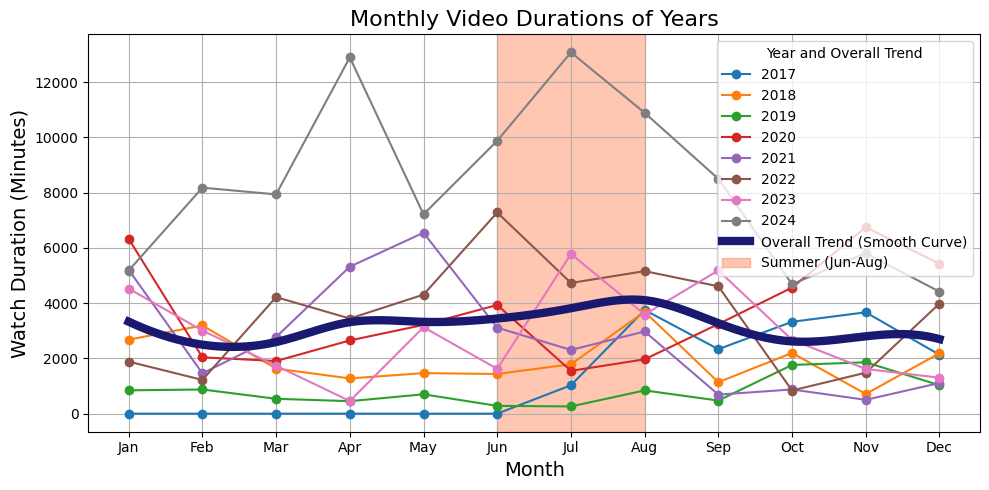

In [98]:
# Run the analysis with the smooth trend curve
test_and_visualize_seasonal_durations_with_curve(years_to_visualize)

#### My Hypothesis is Proven Wrong
There is no significant difference in my summer watch durations.

### "I watched significantly more educational videos in 2022 while preparing for my university entry exam."
Null Hypothesis: No significant difference in educational video watch durations in 2022.                          
Alternative Hypothesis: Educational video watch durations are significantly higher in 2022.

In [201]:
def get_monthly_categories(year,category):
    yearly_data = load_yearly_data(year)
    
    # Initialize a list to hold the total durations for each month (12 months)
    monthly = [0] * 12
    
    # Loop through each month in the data
    for month_data in yearly_data:
        month = month_data["month"] - 1  # Convert month (1-12) to index (0-11)categories_duration = month_data["categories_duration_minutes"]
        categories_duration = month_data["categories_duration_minutes"]
        # Check if the category exists for this month and add its duration
        if str(category) in categories_duration:
            monthly[month] = categories_duration[str(category)]
        else:
            monthly[month] = 0  # If category is not in the month, set it to 0
    
    return monthly
def get_yearly_categories(years,category):
    yearly =[0]*8
    i=0
    for year in years:
        yearly_data =load_yearly_data(year)
        for month_data in yearly_data:
            yearly[i]+=month_data["categories_duration_minutes"].get(str(category), 0)
        i=i+1
    return yearly
category_array= ["1","10","17","20","22","24","26","27"]
def test_hypothesis_categorical_videos(years, category,tyear):
    yearly_categories = get_yearly_categories(years, category)
    category_name = youtube_categories.get(int(category), "Unknown")
    
    # Separate data into test year and non-test year years
    data_tyear = [yearly_categories[years.index(tyear)]]
    non_tyear_durations = [yearly_categories[years.index(year)] for year in years if year != 2022]
    
    # Check if the data for test year is a single value (one data point)
    if len(data_tyear) == 1:
        data_tyear = np.array(data_tyear * len(non_tyear_durations))  # Duplicate the test year data for comparison
    
    # Perform a two-sample t-test (comparing test year against the rest)
    t_stat, p_value = ttest_ind(data_tyear, non_tyear_durations, equal_var=False)  # Welch's t-test

    print(f"T-Statistic: {t_stat:.4f}")
    print(f"P-Value: {p_value:.4f}")
    
    # Interpret results
    if p_value < 0.002:
        print(f"Reject the null hypothesis: Watch durations of '{category_name}' videos are significantly higher in {tyear}.")
        b = True
    else:
        print(f"Fail to reject the null hypothesis: No significant difference in '{category_name}' videos' watch durations in {tyear}.")
        b= False
    
    # Visualization
    plt.figure(figsize=(8, 5))
    plt.bar(years, yearly_categories, color='midnightblue', alpha=1, label=category_name)
    plt.axvspan(tyear - 0.5, tyear + 0.5, color='lightyellow', alpha=0.3)
    
    # Generate smooth curve
    x_smooth = np.linspace(min(years), max(years), 500)
    spline = make_interp_spline(years, yearly_categories, k=3)  # Cubic spline
    y_smooth = spline(x_smooth)
    plt.plot(x_smooth, y_smooth, color="darkred", linewidth=2, label="Trend Curve")
    
    # Add labels and customize
    plt.title(f"Yearly Watched '{category_name}' Category Durations", fontsize=16)
    plt.xlabel("Year", fontsize=14)
    plt.ylabel("Watch Duration (Minutes)", fontsize=14)
    plt.xticks(years, fontsize=12)
    plt.legend(title="Categories", bbox_to_anchor=(1, 1), fontsize=12)
    plt.grid(True, axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()
    

T-Statistic: 8.3324
P-Value: 0.0002
Reject the null hypothesis: Watch durations of 'Education' videos are significantly higher in 2022.


c:\Users\Jade\Downloads\dsa210\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


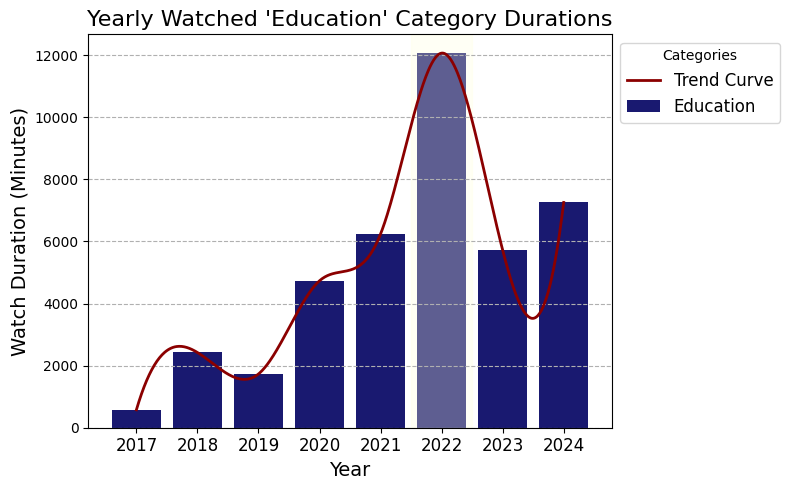

In [202]:
test_hypothesis_categorical_videos(years_to_visualize, "27",2022)

#### My Hypothesis is Proven Right
I watched significanly more educational videos in 2022.

#### In the same sense we can test if "Gaming" category has been watched significantly more than other years in 2024.
Null Hypothesis: No significant change in watch duration of "Gaming" category in 2024.                           
Alternative Hypothesis: There is a significant increase in watch duration of "Gaming" category in 2024.

T-Statistic: 5.9462
P-Value: 0.0010
Reject the null hypothesis: Watch durations of 'Gaming' videos are significantly higher in 2024.


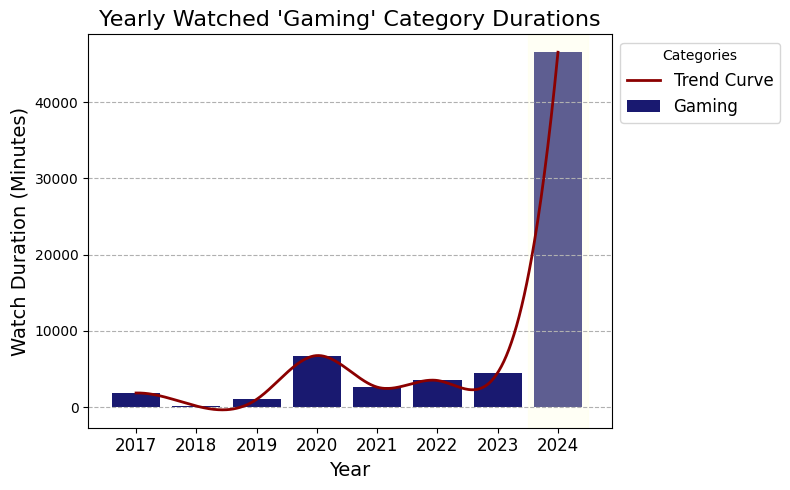

In [203]:
test_hypothesis_categorical_videos(years_to_visualize, "20",2024)

Yes, "Gaming" category is strictly higher in year 2024 than the others.

##### Then i thought maybe i can detect all scenerios where one category is watched significantly more than others in a year.

In [182]:
def test(years, category, tyear):
    yearly_categories = get_yearly_categories(years, category)
    data_tyear = [yearly_categories[years.index(tyear)]]
    non_tyear_durations = [yearly_categories[years.index(year)] for year in years if year != tyear]
    if len(data_tyear) == 1:
        data_tyear = np.array(data_tyear * len(non_tyear_durations)) 
    t_stat, p_value = ttest_ind(data_tyear, non_tyear_durations, equal_var=False)  # Welch's t-test
    if p_value < 0.002: # change it according to the significance level you want
        return True
    return False
def test_all(years_to_analyze, category_array):
    differences_found = []
    for year in years_to_analyze:
        for category in category_array:
            if test(years_to_analyze, category, year):
                differences_found.append((youtube_categories.get(int(category), "Unknown"), year))
    for found in differences_found:
        print(f"Watch durations of {found[0]} videos are significantly higher in {found[1]}.")
test_all(years_to_analyze, category_array)



Watch durations of Howto & Style videos are significantly higher in 2017.
Watch durations of Music videos are significantly higher in 2018.
Watch durations of People & Blogs videos are significantly higher in 2019.
Watch durations of Entertainment videos are significantly higher in 2019.
Watch durations of Film & Animation videos are significantly higher in 2022.
Watch durations of Education videos are significantly higher in 2022.
Watch durations of Sports videos are significantly higher in 2024.
Watch durations of Gaming videos are significantly higher in 2024.


## Analyzing Correlations Between Video Categories using Correlation Matrix

In [101]:
def analyze_category_correlations(year, categories):
    # Prepare a DataFrame for all categories
    category_data = pd.DataFrame(index=range(1, 13))  # 12 months

    for c in categories:
        monthly_categories = get_monthly_categories(year, c)
        category_name = youtube_categories.get(int(c), f"Category {c}")
        category_data[category_name] = monthly_categories

    # Calculate the correlation matrix
    correlation_matrix = category_data.corr()

    # Visualize the correlation matrix
    plt.figure(figsize=(9, 7))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
    plt.title(f"Category Correlations for {year}", fontsize=16)
    plt.show()

    return correlation_matrix

# Example usage
categories_to_analyze = ["1", "10", "17", "20", "22", "24", "26", "27"] 


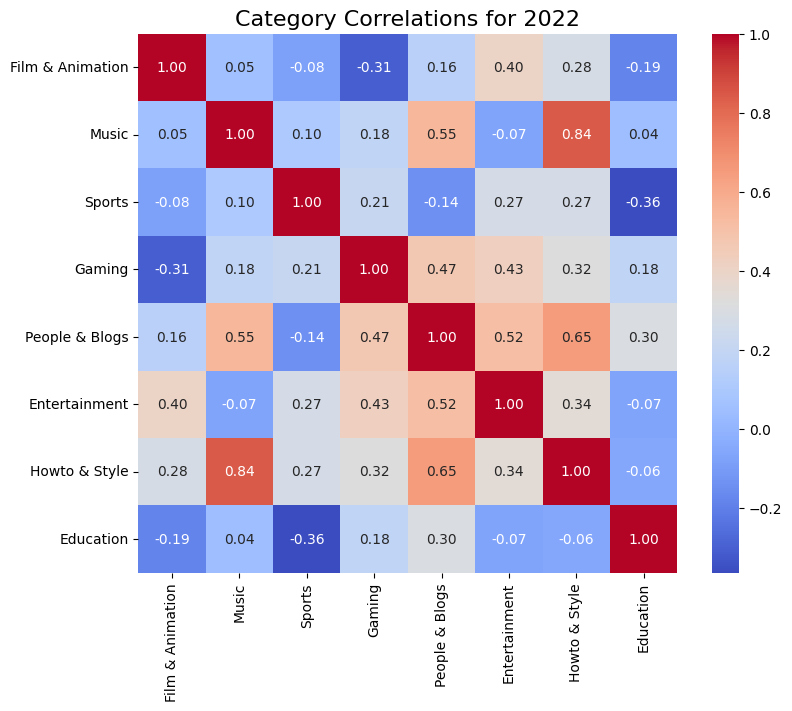

,Film & Animation,Music,Sports,Gaming,People & Blogs,Entertainment,Howto & Style,Education
Film & Animation,1.000000,0.054374,-0.083734,-0.306404,0.156638,0.402302,0.275322,-0.188173
Music,0.054374,1.000000,0.102990,0.180562,0.550499,-0.071306,0.842230,0.044143
Sports,-0.083734,0.102990,1.000000,0.207736,-0.141281,0.271346,0.273599,-0.364610
Gaming,-0.306404,0.180562,0.207736,1.000000,0.469825,0.426421,0.320922,0.181359
People & Blogs,0.156638,0.550499,-0.141281,0.469825,1.000000,0.517516,0.651973,0.297700
Entertainment,0.402302,-0.071306,0.271346,0.426421,0.517516,1.000000,0.344575,-0.070565
Howto & Style,0.275322,0.842230,0.273599,0.320922,0.651973,0.344575,1.000000,-0.057002
Education,-0.188173,0.044143,-0.364610,0.181359,0.297700,-0.070565,-0.057002,1.000000


In [109]:
analyze_category_correlations(2022, categories_to_analyze) # Analyze year "2022"

##### The categories generally do not correlate with each other. But the nearest correlation is between categories "Music" and "Howto & Style" with correlation 0.84 which can be considered as a positive correlation. The reason behind this correlation might be because Howto & Style videos i watch are mostly tutorial videos. I watch a lot of music tutorials (e.g. guitar tabs, piano notes, drum covers etc.)

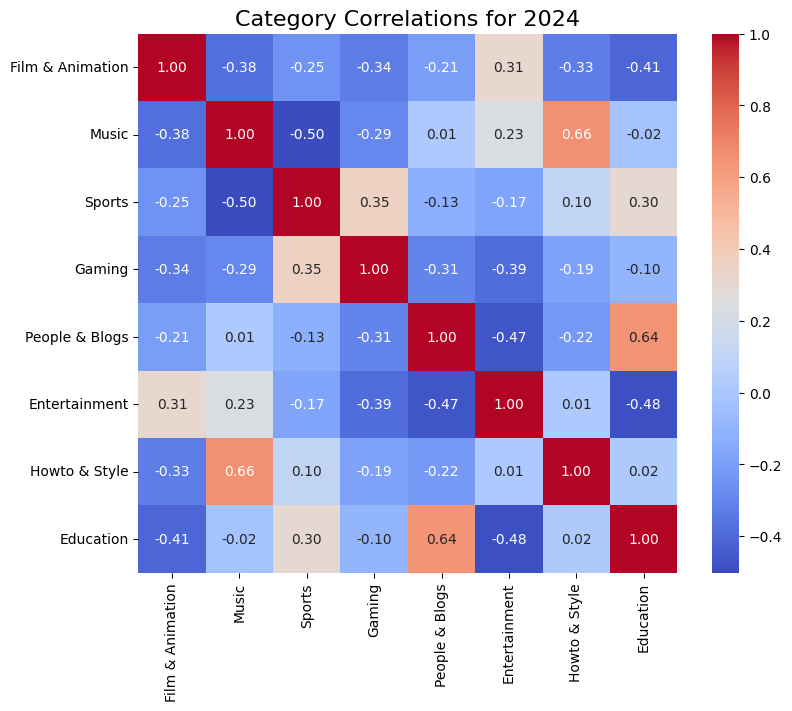

,Film & Animation,Music,Sports,Gaming,People & Blogs,Entertainment,Howto & Style,Education
Film & Animation,1.000000,-0.382157,-0.248002,-0.336391,-0.205749,0.310699,-0.331158,-0.408133
Music,-0.382157,1.000000,-0.501718,-0.291706,0.013021,0.227686,0.655399,-0.021542
Sports,-0.248002,-0.501718,1.000000,0.351335,-0.125363,-0.174389,0.104851,0.298746
Gaming,-0.336391,-0.291706,0.351335,1.000000,-0.306801,-0.389986,-0.190548,-0.101712
People & Blogs,-0.205749,0.013021,-0.125363,-0.306801,1.000000,-0.471732,-0.222766,0.644649
Entertainment,0.310699,0.227686,-0.174389,-0.389986,-0.471732,1.000000,0.013538,-0.484636
Howto & Style,-0.331158,0.655399,0.104851,-0.190548,-0.222766,0.013538,1.000000,0.017837
Education,-0.408133,-0.021542,0.298746,-0.101712,0.644649,-0.484636,0.017837,1.000000


In [ ]:
analyze_category_correlations(2024, categories_to_analyze) #Analyze year "2024"

##### In 2023, there appear to be more negative correlations than positive ones. It seems like I don't diversify my watching habits much, as I tend to focus on one category at a time. However, since these correlations are weak, we cannot draw any definitive conclusions from them.                       
Music & Sports , Edutation & Entertainment video categories are the ones with higher negative correlations which can be predictable as i won't be watching much entertainment videos when for example i'm studying for exams or music and sports are whole different areas to be watching in the same time period.

### Visualizing Monthly Categories of the Years
These plots will illustrate my interests and their evolution over the years.

In [196]:
def visualize_monthly_categories_stackbar(year, categories,custom_colors):
    # Initialize an empty DataFrame for the stacked data
    stacked_data = pd.DataFrame(index=range(1, 13))  # 12 months
    
    # Loop through each category and get the data for that category
    for c in categories:
        monthly_categories = get_monthly_categories(year, c)
        category_name = youtube_categories.get(int(c), "Unknown")
        
        # Add the category's data as a new column in the stacked DataFrame
        stacked_data[category_name] = monthly_categories
    
    # Plot the stacked bar plot
    stacked_data.plot(kind='bar', stacked=True, figsize=(10, 6), color=custom_colors,edgecolor='black')
    
    # Customize the plot
    plt.title(f"Monthly Video Categories Watch Duration in {year}", fontsize=16)
    plt.xlabel("Month", fontsize=14)
    plt.ylabel("Watch Duration (Minutes)", fontsize=14)
    plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=12)
    plt.legend(title="Categories", bbox_to_anchor=(1, 1), fontsize=12)
    plt.grid(True, axis='y', linestyle='--')
    
    # Show the plot
    plt.tight_layout()
    plt.show()
    

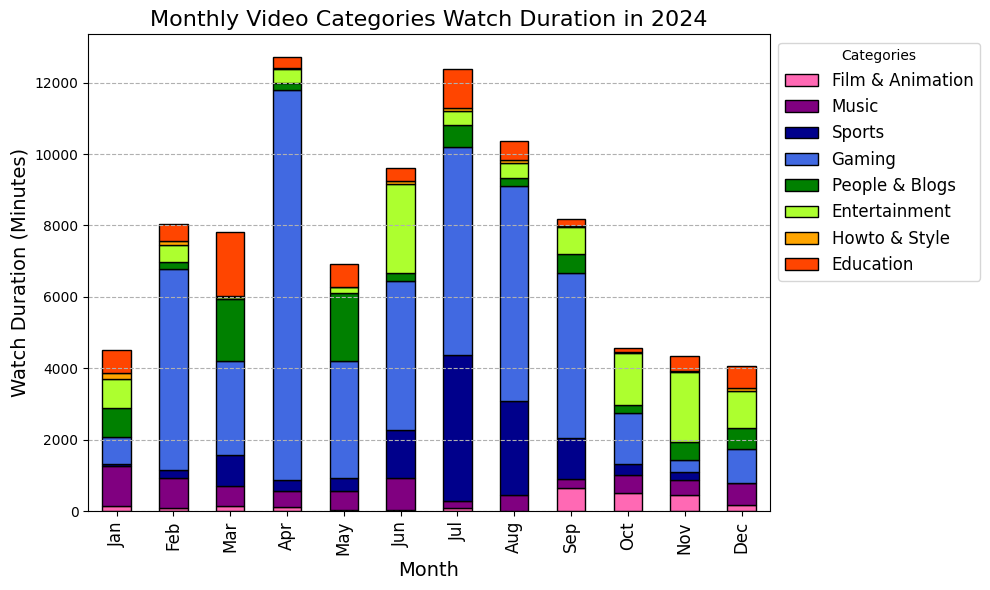

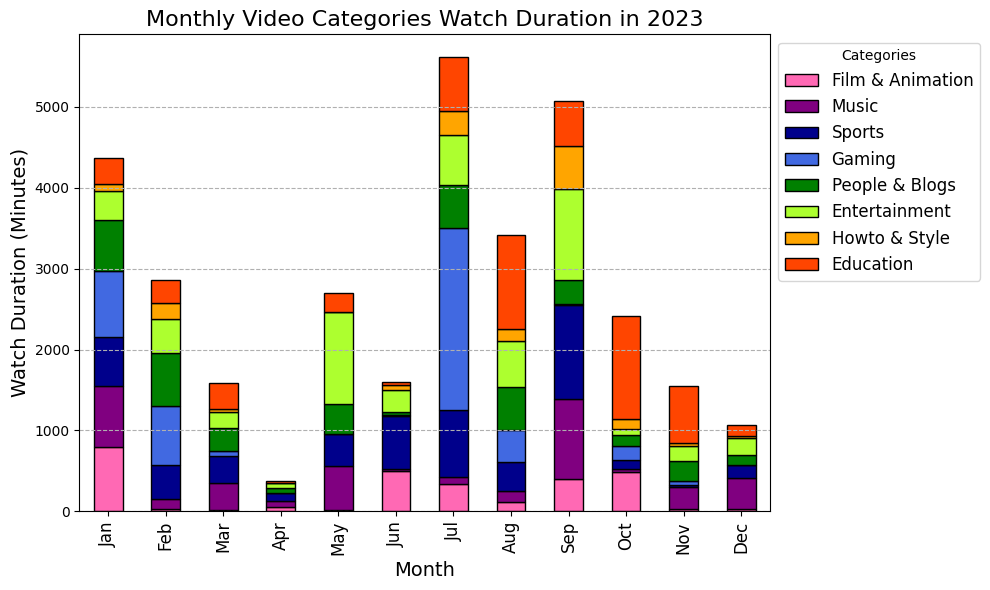

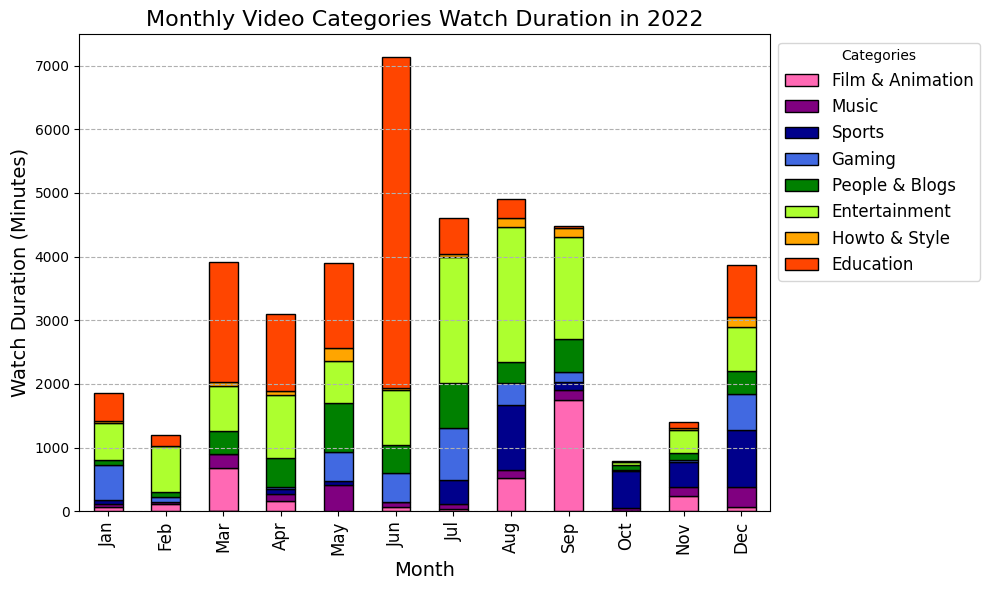

In [206]:
custom_colors=["hotpink","purple","darkblue","royalblue","green","greenyellow","orange","orangered"]
visualize_monthly_categories_stackbar(2024,category_array,custom_colors)
visualize_monthly_categories_stackbar(2023,category_array,custom_colors)
visualize_monthly_categories_stackbar(2022,category_array,custom_colors) # Others are commented, if you want to see the data you can comment them out
# visualize_monthly_categories_stackbar(2021,category_array,custom_colors)
# visualize_monthly_categories_stackbar(2020,category_array,custom_colors)
# visualize_monthly_categories_stackbar(2019,category_array,custom_colors)
# visualize_monthly_categories_stackbar(2018,category_array,custom_colors)
# visualize_monthly_categories_stackbar(2017,category_array,custom_colors)


##### ANALYSIS OF THE PLOTS
1. Comparing year "2023" and "2024" we can see on the y axis the watch duration levels are approximately 2 times of the the year "2023" in "2024".     
2. In year "2023" we see diversification of categories along the year but in year "2024" gaming category dominates other video categories.         
3. In year "2023" the educational videos' proportion is higher than "2024". Showing my reason of using Youtube evolved more into entertainment purpose.

Further analysis and hypothesis testings are possible using linear regression, t-tesing, knn models etc.